###Import Libraries and dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import random
import glob
import time
import math
import pathlib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2 as cv
from PIL import Image, ImageEnhance
from skimage.io import imread
from sklearn.metrics import (
    accuracy_score, f1_score, matthews_corrcoef,
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, precision_recall_fscore_support
)
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_hub as hub
from tensorflow.keras import models, layers, Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, Input, LeakyReLU,
    BatchNormalization, Activation, Conv2D,
    GlobalAveragePooling2D, Lambda
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess_input, EfficientNetB0
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.utils import plot_model

# Suppress warnings
warnings.filterwarnings("ignore")


In [ ]:
DATASET_PATH = "/content/drive/MyDrive/skin_cancer"
TRAIN_PATH = '/content/drive/MyDrive/skin_cancer/train'
TEST_PATH = '/content/drive/MyDrive/skin_cancer/test'

In [ ]:
def count_files(rootdir):
    '''counts the number of files in each subfolder in a directory'''
    for path in pathlib.Path(rootdir).iterdir():
        if path.is_dir():
            print("There are " + str(len([name for name in os.listdir(path) \
            if os.path.isfile(os.path.join(path, name))])) + " files in " + \
            str(path.name))

count_files(os.path.join(TRAIN_PATH))
count_files(os.path.join(TEST_PATH))


There are 1197 files in malignant
There are 1440 files in benign
There are 310 files in malignant
There are 360 files in benign


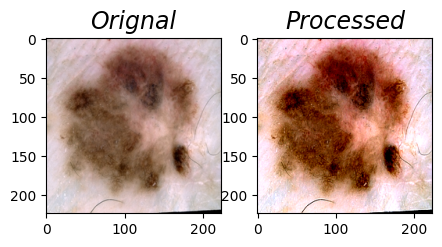

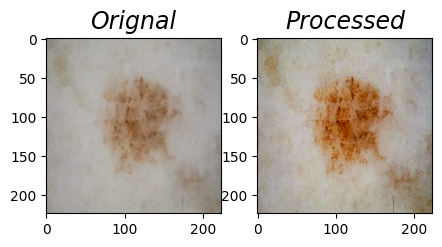

In [ ]:
image_folder="malignant"
number_of_images=2

def Preprocess():
    j=1
    for i in range(number_of_images):

        folder = os.path.join(TEST_PATH,image_folder)
        a=random.choice(os.listdir(folder))

        image=Image.open(os.path.join(folder,a))
        image_duplicate=image.copy()
        plt.figure(figsize=(5,5))

        plt.subplot(number_of_images,2,j)
        plt.title(label='Orignal', size=17, pad='7.0', loc="center", fontstyle='italic')
        plt.imshow(image)
        j+=1

        image1=ImageEnhance.Color(image_duplicate).enhance(1.35)
        image1=ImageEnhance.Contrast(image1).enhance(1.45)
        image1=ImageEnhance.Sharpness(image1).enhance(2.5)

        plt.subplot(number_of_images,2,j)
        plt.title(label='Processed', size=17, pad='7.0', loc="center", fontstyle='italic')
        plt.imshow(image1)
        j+=1

Preprocess()

###Processing test data for each model

####InceptionV3

In [ ]:
# Function to load images and their labels (updated to resize images to 299x299)
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv.imread(img_path)
        if img is not None:
            img = cv.resize(img, (299, 299))  # Resize all images to 299x299 for InceptionV3
            images.append(img)
            labels.append(label)
    return images, labels

# Load Malignant and Benign images from the train folder
train_malignant_images, train_malignant_labels = load_images_from_folder(os.path.join(TRAIN_PATH, 'malignant'), label=1)
train_benign_images, train_benign_labels = load_images_from_folder(os.path.join(TRAIN_PATH, 'benign'), label=0)

# Combine Malignant and Benign for training data
X_train = np.array(train_malignant_images + train_benign_images)
y_train = np.array(train_malignant_labels + train_benign_labels)

# Load Malignant and Benign images from the test folder
test_malignant_images, test_malignant_labels = load_images_from_folder(os.path.join(TEST_PATH, 'malignant'), label=1)
test_benign_images, test_benign_labels = load_images_from_folder(os.path.join(TEST_PATH, 'benign'), label=0)

# Combine Malignant and Benign for testing data, and rename to 'inception_X_test' and 'inception_y_test'
inception_X_test = np.array(test_malignant_images + test_benign_images)
inception_y_test = np.array(test_malignant_labels + test_benign_labels)


####Efficientnet

In [ ]:
# Function to load images and their labels
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv.imread(img_path)
        if img is not None:
            img = cv.resize(img, (128, 128))  # Resize all images to 128x128
            images.append(img)
            labels.append(label)
    return images, labels

# Load Malignant and Benign images from the train folder
train_malignant_images, train_malignant_labels = load_images_from_folder(os.path.join(TRAIN_PATH, 'malignant'), label=1)
train_benign_images, train_benign_labels = load_images_from_folder(os.path.join(TRAIN_PATH, 'benign'), label=0)

# Combine Malignant and Benign for training data
X_train = np.array(train_malignant_images + train_benign_images)
y_train = np.array(train_malignant_labels + train_benign_labels)

# Load Malignant and Benign images from the test folder
test_malignant_images, test_malignant_labels = load_images_from_folder(os.path.join(TEST_PATH, 'malignant'), label=1)
test_benign_images, test_benign_labels = load_images_from_folder(os.path.join(TEST_PATH, 'benign'), label=0)

# Combine Malignant and Benign for testing data, and rename to 'efficientnet_X_test' and 'efficientnet_y_test'
efficientnet_X_test = np.array(test_malignant_images + test_benign_images)
efficientnet_y_test = np.array(test_malignant_labels + test_benign_labels)


####EfficientnetB0

In [ ]:
# Function to load images and their labels
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv.imread(img_path)
        if img is not None:
            img = cv.resize(img, (224, 224))  # Resize all images to 224x224 for EfficientNet
            images.append(img)
            labels.append(label)
    return images, labels

# Load Malignant and Benign images from the train folder
train_malignant_images, train_malignant_labels = load_images_from_folder(os.path.join(TRAIN_PATH, 'malignant'), label=1)
train_benign_images, train_benign_labels = load_images_from_folder(os.path.join(TRAIN_PATH, 'benign'), label=0)

# Combine Malignant and Benign for training data
X_train = np.array(train_malignant_images + train_benign_images)
y_train = np.array(train_malignant_labels + train_benign_labels)

# Load Malignant and Benign images from the test folder
test_malignant_images, test_malignant_labels = load_images_from_folder(os.path.join(TEST_PATH, 'malignant'), label=1)
test_benign_images, test_benign_labels = load_images_from_folder(os.path.join(TEST_PATH, 'benign'), label=0)

# Combine Malignant and Benign for testing data, and rename to 'efficientnet_X_test' and 'efficientnet_y_test'
efficientnetb0_X_test = np.array(test_malignant_images + test_benign_images)
efficientnetb0_y_test = np.array(test_malignant_labels + test_benign_labels)


###Loading models

In [ ]:

efficientnet_model_path = "/content/drive/MyDrive/skin_cancer/efficientnet_model.keras"
efficientnetb0_model_path = "/content/drive/MyDrive/skin_cancer/efficientnetb0.keras"
inceptionv3_model_path = "/content/drive/MyDrive/skin_cancer/inceptionv3_model.keras"

efficientnetb0_model = tf.keras.models.load_model(efficientnetb0_model_path)
inceptionv3_model = tf.keras.models.load_model(inceptionv3_model_path)
efficientnet_model = tf.keras.models.load_model(efficientnet_model_path)


In [ ]:
inceptionv3_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 299, 299, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 149, 149, 32)   │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 149, 149, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 149, 149, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 147, 147, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 147, 147, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 147, 147, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 147, 147, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 147, 147, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 73, 73, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 73, 73, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 73, 73, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 71, 71, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 71, 71, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 22,327,588 (85.17 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

 Optimizer params: 262,403 (1.00 MB)

In [ ]:
efficientnet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 128, 128, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 128, 128, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 128, 128, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 129, 129, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 64, 64, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 64, 64, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 64, 64, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 64, 64, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 64, 64, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 64, 64, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,377,767 (16.70 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 164,099 (641.02 KB)

In [ ]:
efficientnetb0_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_4 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_2           │ (None, 224, 224, 3)    │              7 │ rescaling_4[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_5 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_5[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,377,767 (16.70 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 164,099 (641.02 KB)

###Testing accuracy

In [ ]:
inception_test_loss, inception_test_acc = inceptionv3_model.evaluate(inception_X_test, inception_y_test)
print(f"Test Accuracy: {inception_test_acc}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 187s 9s/step - accuracy: 0.8176 - loss: 0.4089
Test Accuracy: 0.8179104328155518


In [ ]:
inception_y_pred = (inceptionv3_model.predict(inception_X_test) > 0.5).astype("int32")
print("\nClassification Report:\n", classification_report(inception_y_test, inception_y_pred))

21/21 ━━━━━━━━━━━━━━━━━━━━ 266s 13s/step

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.79      0.82       360
           1       0.77      0.85      0.81       310

    accuracy                           0.82       670
   macro avg       0.82      0.82      0.82       670
weighted avg       0.82      0.82      0.82       670



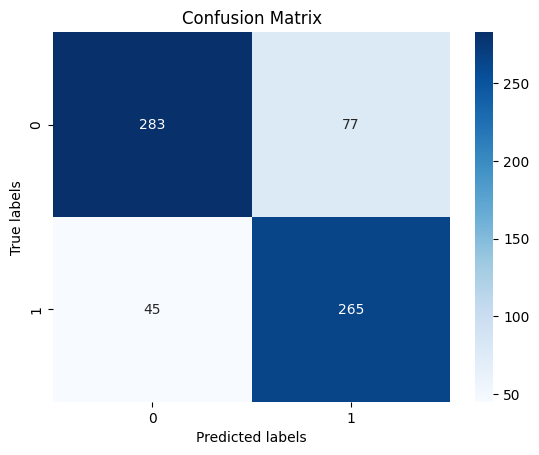

In [ ]:
cm = confusion_matrix(inception_y_test, inception_y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
efficentnetb0_test_loss, efficientnetb0_test_acc = efficientnetb0_model.evaluate(efficientnetb0_X_test, efficientnetb0_y_test)
print(f"Test Accuracy: {efficientnetb0_test_acc}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.8922 - loss: 0.2750
Test Accuracy: 0.7850746512413025


In [ ]:
efficientnetb0_y_pred = (efficientnetb0_model.predict(efficientnetb0_X_test) > 0.5).astype("int32")
print(classification_report(efficientnetb0_y_test, efficientnetb0_y_pred))

21/21 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step
              precision    recall  f1-score   support

           0       0.97      0.62      0.76       360
           1       0.69      0.98      0.81       310

    accuracy                           0.79       670
   macro avg       0.83      0.80      0.78       670
weighted avg       0.84      0.79      0.78       670



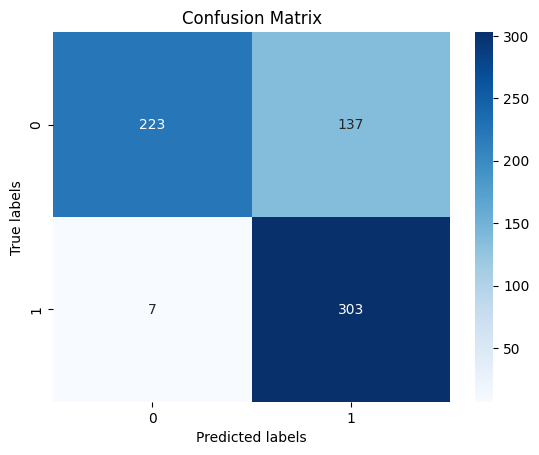

In [ ]:
cm = confusion_matrix(efficientnetb0_y_test, efficientnetb0_y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
efficentnet_test_loss, efficientnet_test_acc = efficientnet_model.evaluate(efficientnet_X_test, efficientnet_y_test)
print(f"Test Accuracy: {efficientnet_test_acc}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 683ms/step - accuracy: 0.8604 - loss: 0.3075
Test Accuracy: 0.8268656730651855


In [ ]:
efficientnet_y_pred = (efficientnet_model.predict(efficientnet_X_test) > 0.5).astype("int32")
print("\nClassification Report:\n", classification_report(efficientnet_y_test, efficientnet_y_pred))

21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 810ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.75      0.82       360
           1       0.76      0.92      0.83       310

    accuracy                           0.83       670
   macro avg       0.84      0.83      0.83       670
weighted avg       0.84      0.83      0.83       670



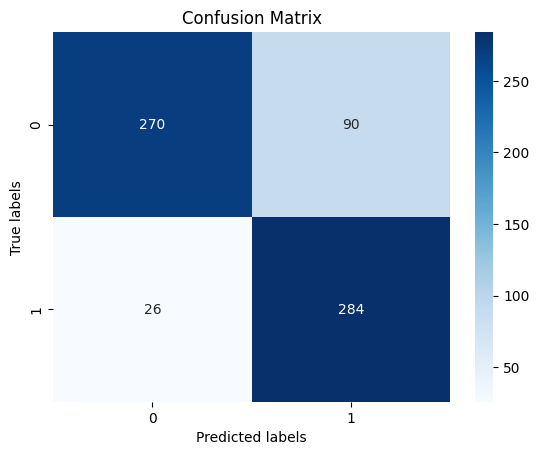

In [ ]:
cm = confusion_matrix(efficientnet_y_test, efficientnet_y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
data = {'Model': ['InceptionV3', 'EfficientNetB0(224x224)','EfiicientNet(128x128)'],
        'Test Accuracy': [inception_test_acc, efficientnetb0_test_acc,efficientnet_test_acc],
        'Test Loss': [inception_test_loss, efficentnetb0_test_loss,efficentnet_test_loss]}

df = pd.DataFrame(data)
print(df)

                     Model  Test Accuracy  Test Loss
0              InceptionV3       0.817910   0.385664
1  EfficientNetB0(224x224)       0.785075   0.481917
2    EfiicientNet(128x128)       0.826866   0.381843


###Prediction

####efficientnet

In [ ]:
def predict_image(filename, model, target_size=(224, 224), preprocess_func=None):

    # Load image with the specified target size
    img_ = image.load_img(filename, target_size=target_size)
    img_array = image.img_to_array(img_)

    # Expand dimensions to create a batch of one image
    img_processed = np.expand_dims(img_array, axis=0)

    # Apply model-specific preprocessing if a function is provided
    if preprocess_func:
        img_processed = preprocess_func(img_processed)

    # Model prediction
    prediction = model.predict(img_processed)

    # Interpret the prediction based on a binary classification threshold
    if prediction > 0.5:
        pred = 'malignant'
    else:
        pred = 'benign'

    # Display the image with its predicted category
    plt.title(f"Prediction - {pred}")
    plt.imshow(img_array / 255.0)  # Normalize for display
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


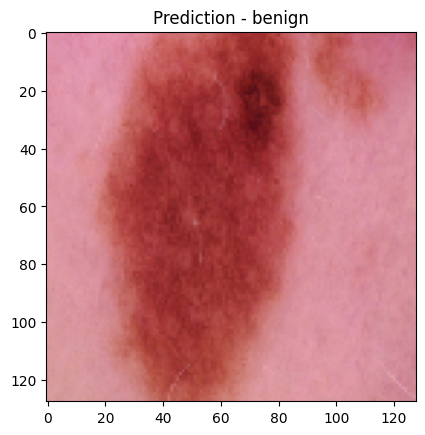

In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess_input
predict_image('/content/drive/MyDrive/skin_cancer/test/benign/1003.jpg', efficientnet_model, target_size=(128, 128), preprocess_func=efficientnet_preprocess_input)


####efficientnetb0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


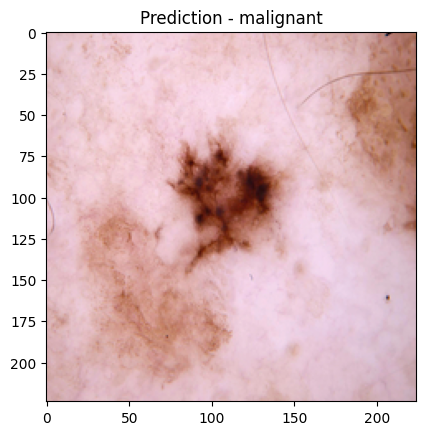

In [ ]:
predict_image('/content/drive/MyDrive/skin_cancer/test/malignant/1003.jpg', efficientnetb0_model, target_size=(224, 224), preprocess_func=efficientnet_preprocess_input)

####inceptionv3

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


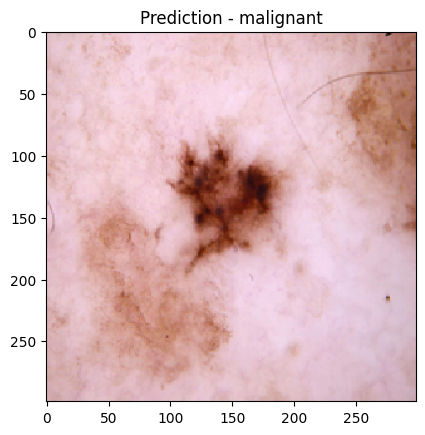

In [ ]:
predict_image('/content/drive/MyDrive/skin_cancer/test/malignant/1003.jpg', inceptionv3_model, target_size=(299, 299), preprocess_func=efficientnet_preprocess_input)

###EXPLAINABLE AI

####Grad-CAM

In [ ]:
import numpy as np
import tensorflow as tf
import cv2 as cv
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess_input
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess_input

inceptionv3_model = tf.keras.models.load_model(inceptionv3_model_path)
efficientnetb0_model = tf.keras.models.load_model(efficientnetb0_model_path)


In [ ]:
# Function to generate Grad-CAM heatmap
def generate_gradcam_heatmap(model, img_array, layer_name, class_idx):
    """
    Generate Grad-CAM heatmap for a given model and image.

    Args:
        model (tf.keras.Model): The model to generate Grad-CAM for.
        img_array (numpy array): Preprocessed image input.
        layer_name (str): Name of the convolutional layer to compute Grad-CAM.
        class_idx (int): Index of the class to compute the gradients for.

    Returns:
        heatmap (numpy array): The generated heatmap.
    """
    # Get the model output and the specified layer
    with tf.GradientTape() as tape:
        last_conv_layer = model.get_layer(layer_name)
        iterate = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])
        conv_output, predictions = iterate(img_array)

        # Ensure predictions is a tensor, even if it's returned as a list
        if isinstance(predictions, list):
            predictions = predictions[0]

        loss = predictions[:, class_idx]

    # Compute gradients
    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_output = conv_output[0]
    heatmap = conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.reduce_mean(heatmap, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap


In [ ]:
# Function to process image, generate Grad-CAM, and display results
def display_gradcam(model, img_path, layer_name, preprocess_func, input_size=(299, 299)):

    # Load and preprocess the image
    img = image.load_img(img_path, target_size=input_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_func(img_array)  # Preprocess based on the model's requirements

    # Predict and generate heatmap
    class_idx = np.argmax(model.predict(img_array))
    heatmap = generate_gradcam_heatmap(model, img_array, layer_name, class_idx)

    # Load and resize original image for visualization
    original_img = cv.imread(img_path)
    original_img = cv.resize(original_img, input_size)  # Resize to match input size

    # Resize heatmap to match original image
    heatmap_resized = cv.resize(heatmap, (original_img.shape[1], original_img.shape[0]))

    # Convert heatmap to 8-bit and apply colormap
    heatmap_img = np.uint8(255 * heatmap_resized)
    heatmap_img = cv.applyColorMap(heatmap_img, cv.COLORMAP_JET)

    # Superimpose heatmap onto the original image
    superimposed_img = cv.addWeighted(heatmap_img, 0.4, original_img, 0.6, 0)

    # Display original image and Grad-CAM heatmap
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(image.array_to_img(img_array[0]))
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(cv.cvtColor(superimposed_img, cv.COLOR_BGR2RGB))
    plt.title('Grad-CAM')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


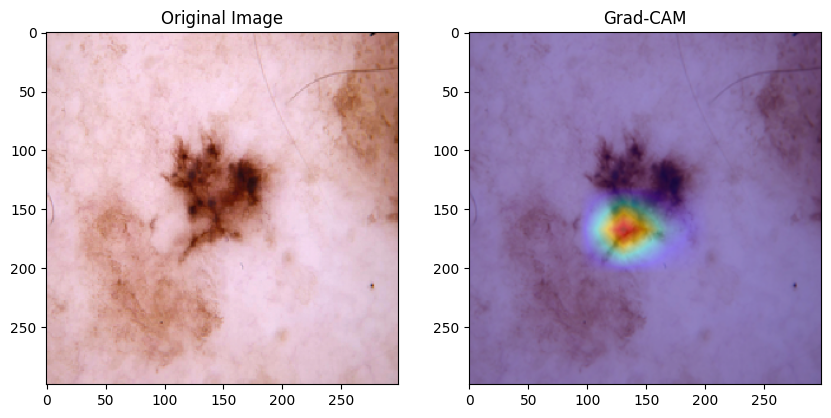

In [ ]:
# Example usage for InceptionV3
display_gradcam(inceptionv3_model,
                img_path='/content/drive/MyDrive/skin_cancer/test/malignant/1003.jpg',
                layer_name='mixed10',  # Final conv layer in InceptionV3
                preprocess_func=inception_preprocess_input,
                input_size=(299, 299))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


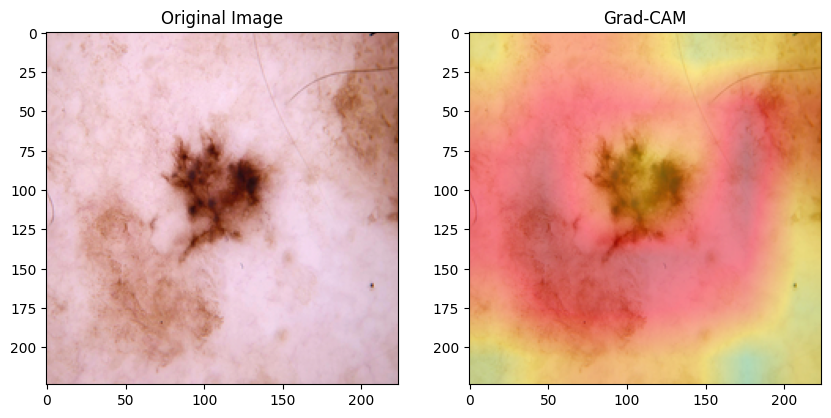

In [ ]:
# Example usage for EfficientNet
display_gradcam(efficientnetb0_model,
                img_path='/content/drive/MyDrive/skin_cancer/test/malignant/1003.jpg',
                layer_name='top_conv',  # Final conv layer in EfficientNet
                preprocess_func=efficientnet_preprocess_input,
                input_size=(224, 224))

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


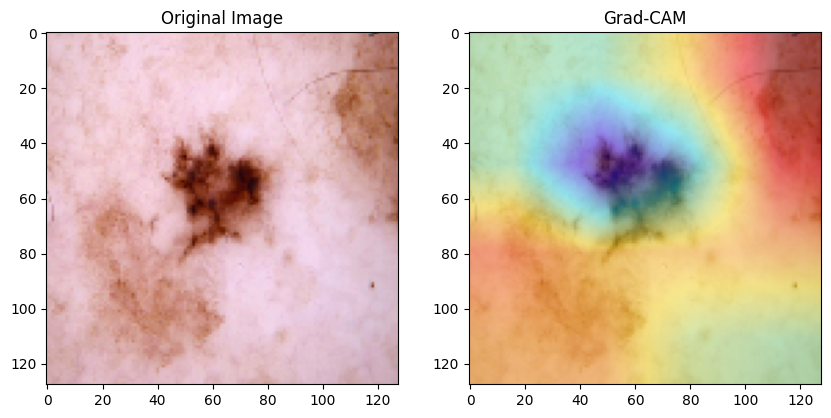

In [ ]:
display_gradcam(efficientnet_model,
                img_path='/content/drive/MyDrive/skin_cancer/test/malignant/1003.jpg',
                layer_name='top_conv',  # Final conv layer in EfficientNet
                preprocess_func=efficientnet_preprocess_input,
                input_size=(128, 128))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


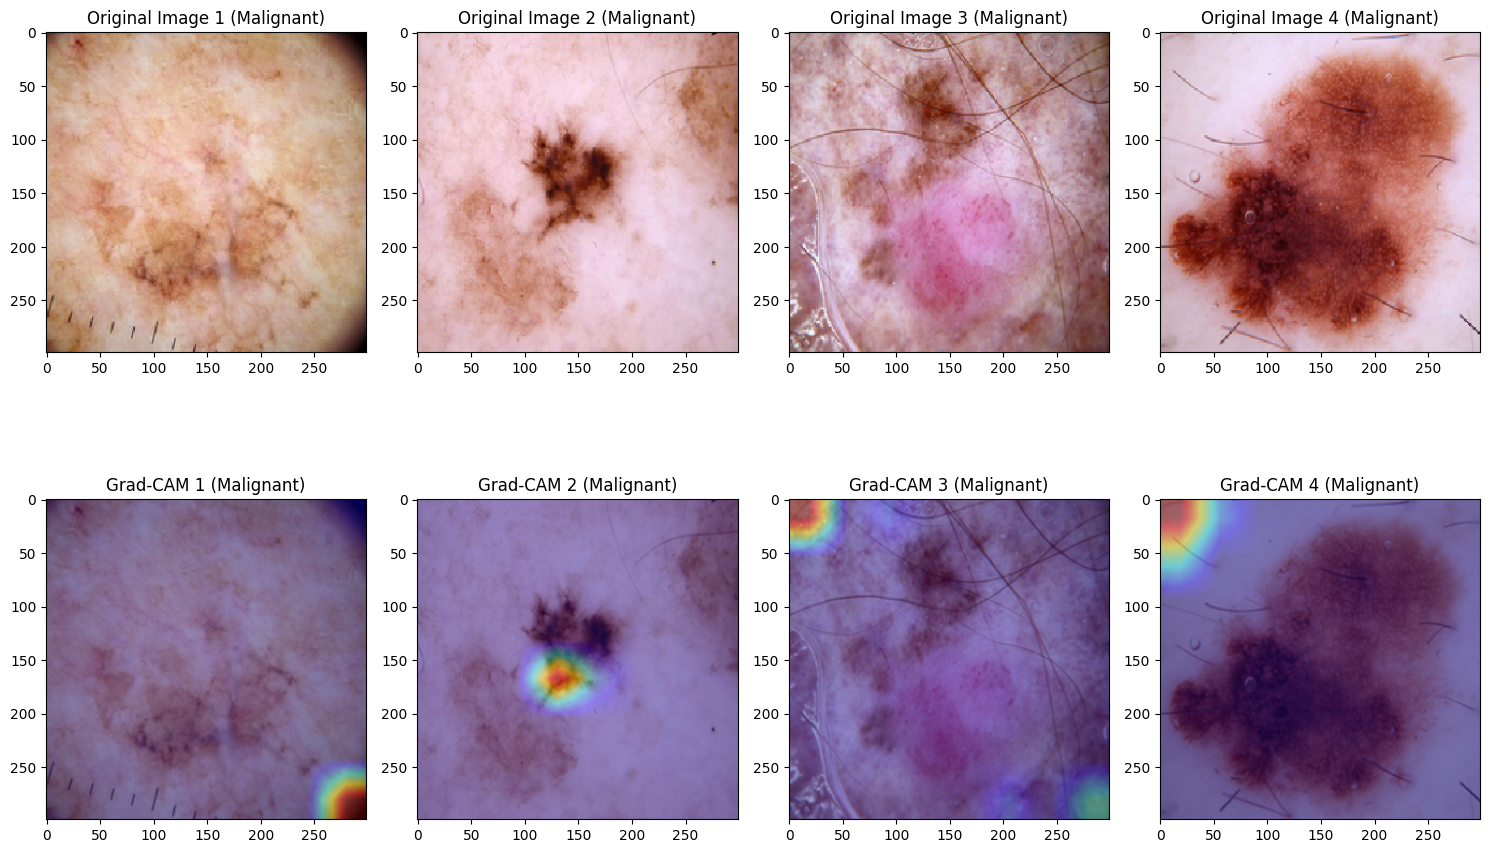

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


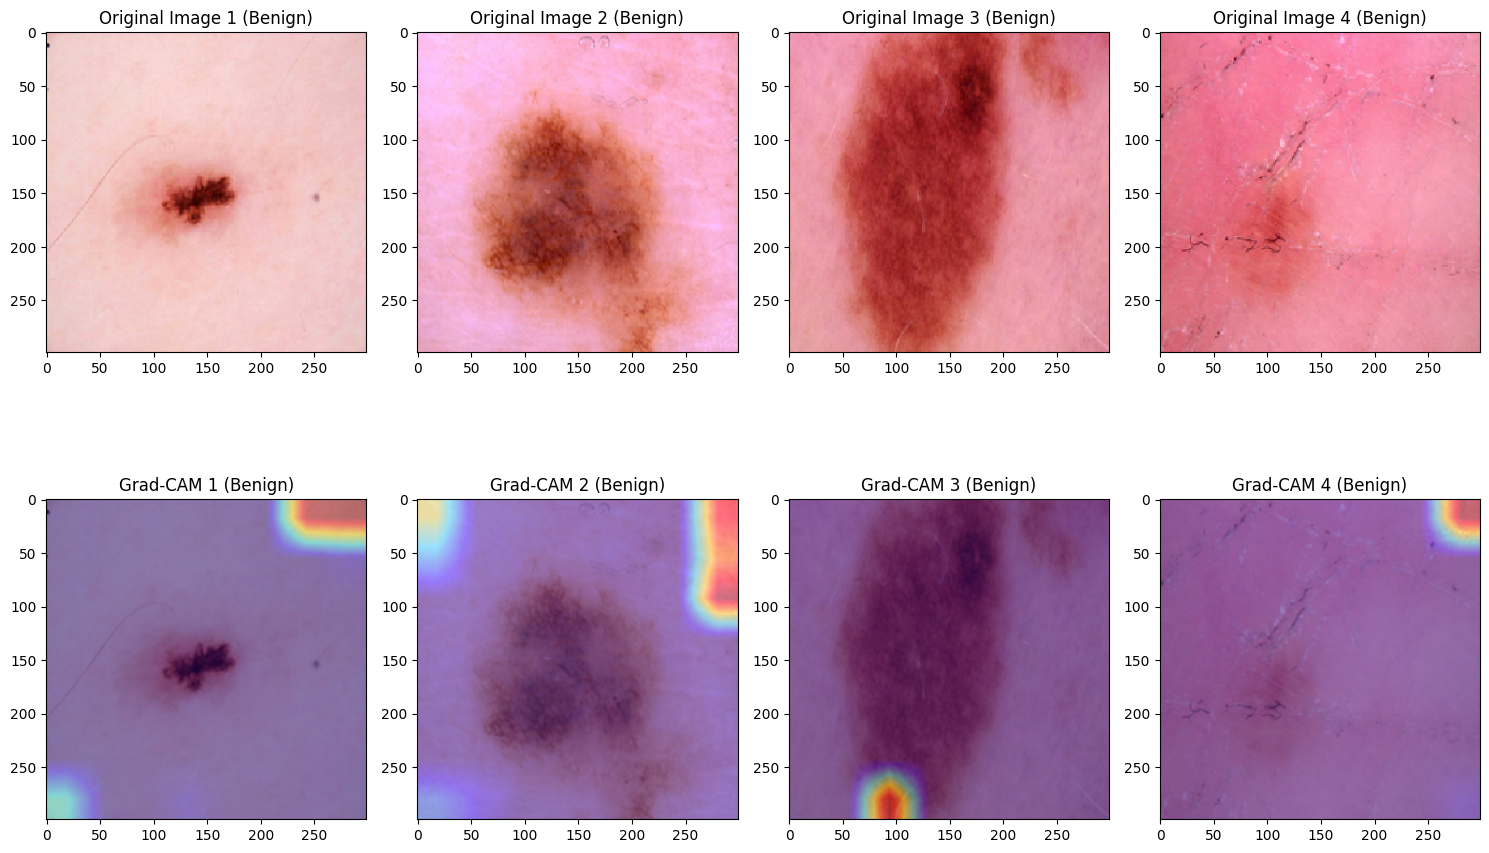

In [17]:
import os
import numpy as np
import tensorflow as tf
import cv2 as cv
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image

# Function to generate Grad-CAM heatmap
def generate_gradcam_heatmap(model, img_array, layer_name, class_idx):
    with tf.GradientTape() as tape:
        last_conv_layer = model.get_layer(layer_name)
        iterate = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])
        conv_output, predictions = iterate(img_array)

        # Ensure predictions is a tensor, even if it's returned as a list
        if isinstance(predictions, list):
            predictions = predictions[0]

        loss = predictions[:, class_idx]

    # Compute gradients
    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_output = conv_output[0]
    heatmap = conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.reduce_mean(heatmap, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap

# Function to process and display first 4 Grad-CAM heatmaps
def display_multiple_gradcam(model, image_dir, label, layer_name, preprocess_func, input_size=(299, 299)):
    # Get first 4 image paths
    image_paths = sorted(os.listdir(image_dir))[:4]

    # Load and preprocess the images
    images = []
    for img_path in image_paths:
        img = image.load_img(os.path.join(image_dir, img_path), target_size=input_size)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_func(img_array)
        images.append((img_array, img_path))

    # Generate and display Grad-CAM heatmaps for the images
    plt.figure(figsize=(15, 10))
    for i, (img_array, img_path) in enumerate(images):
        # Get class prediction
        class_idx = np.argmax(model.predict(img_array))

        # Generate Grad-CAM heatmap
        heatmap = generate_gradcam_heatmap(model, img_array, layer_name, class_idx)

        # Load and resize the original image for visualization
        original_img = cv.imread(os.path.join(image_dir, img_path))
        original_img = cv.resize(original_img, input_size)
        heatmap_resized = cv.resize(heatmap, (original_img.shape[1], original_img.shape[0]))

        # Convert heatmap to 8-bit and apply colormap
        heatmap_img = np.uint8(255 * heatmap_resized)
        heatmap_img = cv.applyColorMap(heatmap_img, cv.COLORMAP_JET)

        # Superimpose heatmap onto the original image
        superimposed_img = cv.addWeighted(heatmap_img, 0.4, original_img, 0.6, 0)

        # Display original image and Grad-CAM
        plt.subplot(2, 4, i + 1)
        plt.imshow(image.array_to_img(img_array[0]))
        plt.title(f'Original Image {i+1} ({label})')

        plt.subplot(2, 4, i + 5)
        plt.imshow(cv.cvtColor(superimposed_img, cv.COLOR_BGR2RGB))
        plt.title(f'Grad-CAM {i+1} ({label})')

    plt.tight_layout()
    plt.show()

# Set the image directories for malignant and benign images
malignant_image_dir = '/content/drive/MyDrive/skin_cancer/test/malignant/'
benign_image_dir = '/content/drive/MyDrive/skin_cancer/test/benign/'

# Set the layer name for Grad-CAM in InceptionV3
layer_name = 'mixed10'

# Display Grad-CAM for the first 4 malignant images
display_multiple_gradcam(inceptionv3_model, malignant_image_dir, label='Malignant', layer_name=layer_name, preprocess_func=preprocess_input, input_size=(299, 299))

# Display Grad-CAM for the first 4 benign images
display_multiple_gradcam(inceptionv3_model, benign_image_dir, label='Benign', layer_name=layer_name, preprocess_func=preprocess_input, input_size=(299, 299))


####Pre-trained Xception model on imagenet

91884032/91884032 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


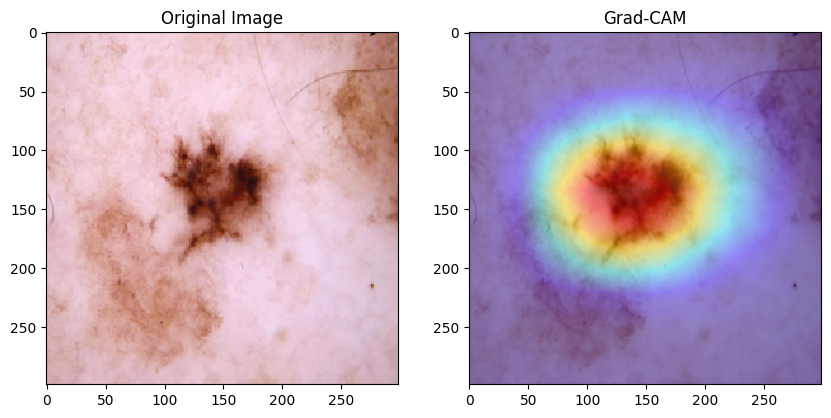

In [24]:
import numpy as np
import tensorflow as tf
import cv2 as cv
import matplotlib.pyplot as plt
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing import image

# Load the Xception model
model = Xception(weights='imagenet')

# Define a function to generate Grad-CAM heatmap
def generate_gradcam_heatmap(model, img_array, layer_name, class_idx):
    # Get the model output and the specified layer
    with tf.GradientTape() as tape:
        last_conv_layer = model.get_layer(layer_name)
        iterate = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])
        conv_output, predictions = iterate(img_array)
        loss = predictions[:, class_idx]

    # Compute gradients
    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_output = conv_output[0]
    heatmap = conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.reduce_mean(heatmap, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap

# Load and preprocess the image
img_path = '/content/drive/MyDrive/skin_cancer/test/malignant/1003.jpg'  # Replace with your image path
img = image.load_img(img_path, target_size=(299, 299))  # Xception requires 299x299 images
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)  # Preprocess the input for Xception model

# Generate heatmap
layer_name = 'block14_sepconv2_act'  # The final convolutional layer in Xception
class_idx = np.argmax(model.predict(img_array))  # Index of the predicted class
heatmap = generate_gradcam_heatmap(model, img_array, layer_name, class_idx)

# Load the original image
original_img = cv.imread(img_path)
original_img = cv.resize(original_img, (299, 299))  # Resize to the size of input image

# Resize heatmap to match original image size
heatmap_resized = cv.resize(heatmap, (original_img.shape[1], original_img.shape[0]))

# Convert heatmap to 8-bit
heatmap_img = np.uint8(255 * heatmap_resized)

# Apply colormap and blend with original image
heatmap_img = cv.applyColorMap(heatmap_img, cv.COLORMAP_JET)
superimposed_img = cv.addWeighted(heatmap_img, 0.4, original_img, 0.6, 0)

# Display the original image and Grad-CAM
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image.array_to_img(img_array[0]))
plt.title('Original Image')

plt.subplot(1, 2, 2)
cv.imwrite('heatmap_result.jpg', superimposed_img)
plt.imshow(cv.cvtColor(superimposed_img, cv.COLOR_BGR2RGB))
plt.title('Grad-CAM')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


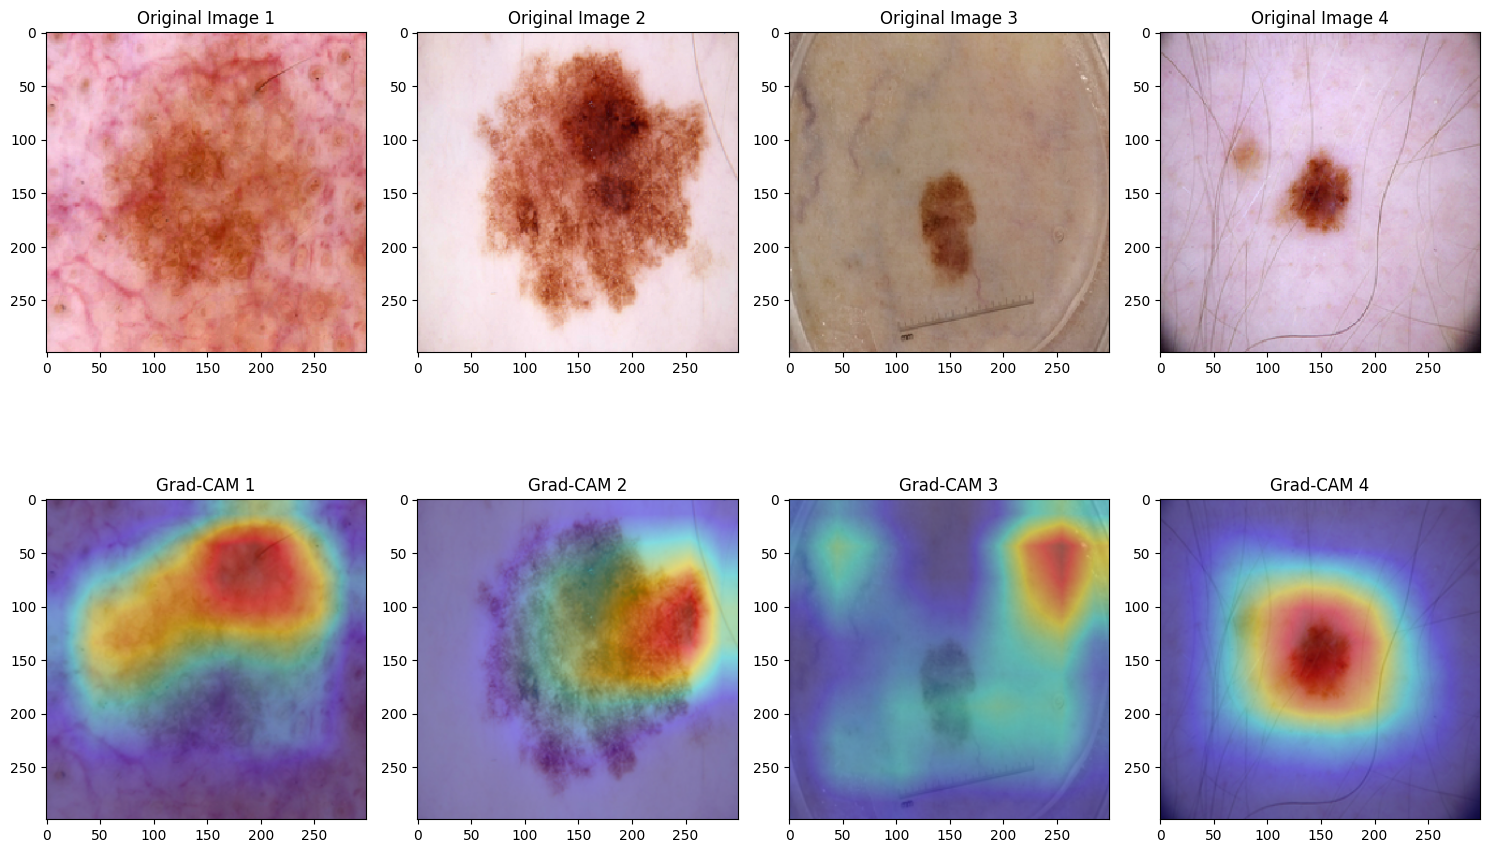

In [25]:

import random

# Define the path to the image directory
image_dir = '/content/drive/MyDrive/skin_cancer/test/malignant/'

# Choose 4 random image paths
image_paths = random.sample(os.listdir(image_dir), 4)

# Load and preprocess the images
images = []
for img_path in image_paths:
    img = image.load_img(os.path.join(image_dir, img_path), target_size=(299, 299))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    images.append(img_array)

# Generate Grad-CAM heatmaps for each image
heatmaps = []
for img_array in images:
    layer_name = 'block14_sepconv2_act'
    class_idx = np.argmax(model.predict(img_array))
    heatmap = generate_gradcam_heatmap(model, img_array, layer_name, class_idx)
    heatmaps.append(heatmap)


# Display original images and Grad-CAMs in a 4x4 matrix
plt.figure(figsize=(15, 10))

for i in range(4):
  # Original image
  plt.subplot(2, 4, i + 1)
  plt.imshow(image.array_to_img(images[i][0]))
  plt.title(f'Original Image {i+1}')

  # Grad-CAM
  original_img = cv.imread(os.path.join(image_dir, image_paths[i]))
  original_img = cv.resize(original_img, (299, 299))
  heatmap_resized = cv.resize(heatmaps[i], (original_img.shape[1], original_img.shape[0]))
  heatmap_img = np.uint8(255 * heatmap_resized)
  heatmap_img = cv.applyColorMap(heatmap_img, cv.COLORMAP_JET)
  superimposed_img = cv.addWeighted(heatmap_img, 0.4, original_img, 0.6, 0)

  plt.subplot(2, 4, i + 5)
  plt.imshow(cv.cvtColor(superimposed_img, cv.COLOR_BGR2RGB))
  plt.title(f'Grad-CAM {i+1}')

plt.tight_layout()
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


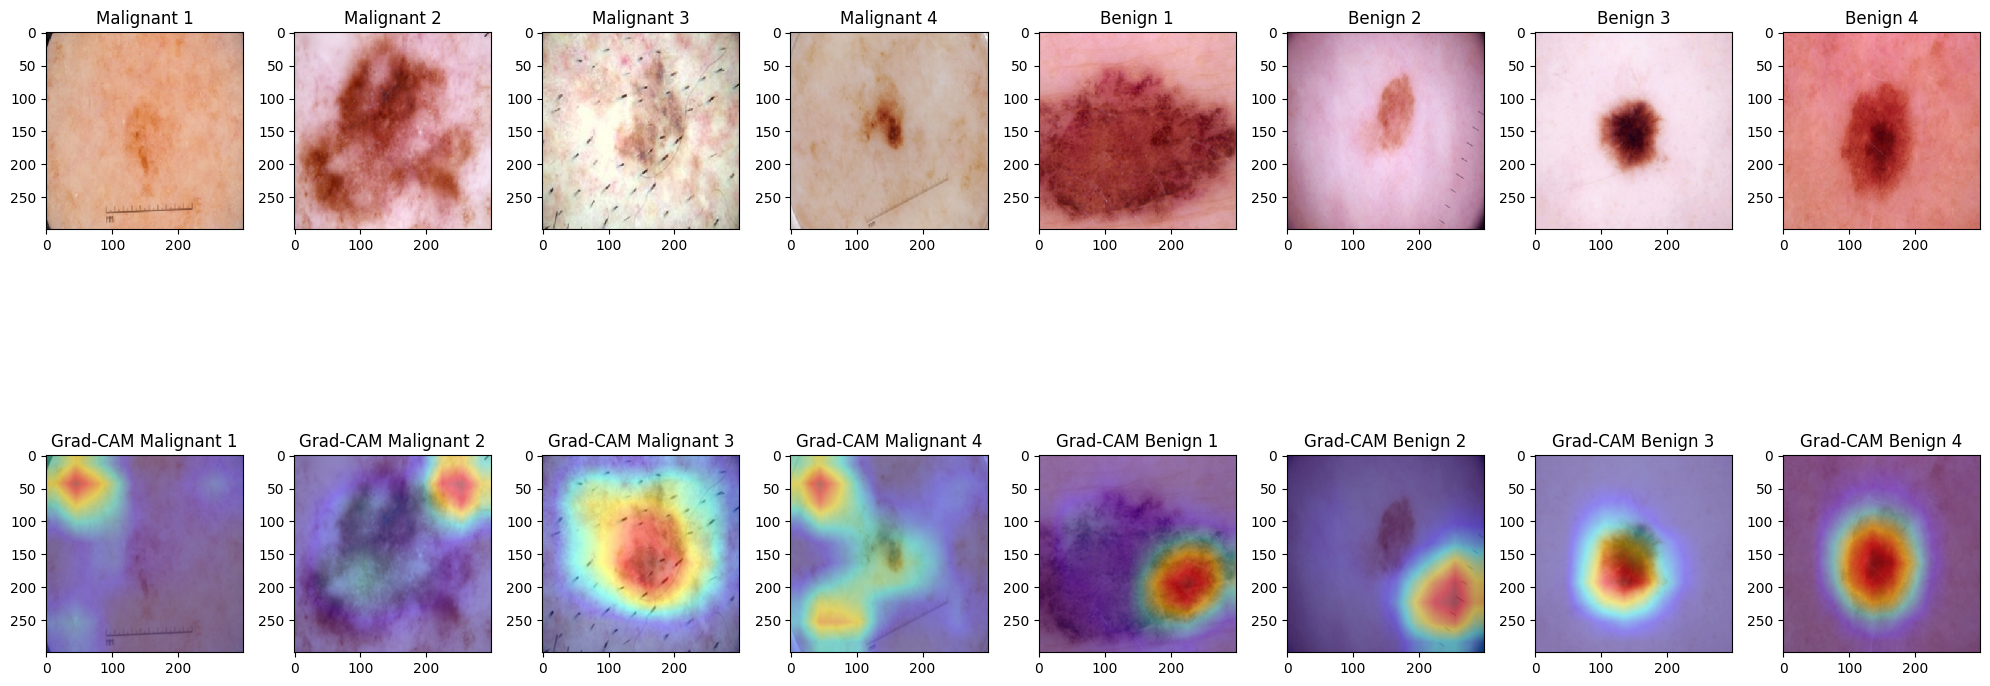

In [26]:
import os
import random
import numpy as np
import tensorflow as tf
import cv2 as cv
import matplotlib.pyplot as plt
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing import image

# Load the Xception model
model = Xception(weights='imagenet')

# Assuming `generate_gradcam_heatmap` function is already defined for Xception
def generate_gradcam_heatmap(model, img_array, layer_name, class_idx):
    with tf.GradientTape() as tape:
        last_conv_layer = model.get_layer(layer_name)
        iterate = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])
        conv_output, predictions = iterate(img_array)
        loss = predictions[:, class_idx]

    # Compute gradients
    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_output = conv_output[0]
    heatmap = conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.reduce_mean(heatmap, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap

# Define the paths to the malignant and benign image directories
malignant_image_dir = '/content/drive/MyDrive/skin_cancer/test/malignant/'
benign_image_dir = '/content/drive/MyDrive/skin_cancer/test/benign/'

# Choose 4 random image paths from each directory
malignant_image_paths = random.sample(os.listdir(malignant_image_dir), 4)
benign_image_paths = random.sample(os.listdir(benign_image_dir), 4)

# Function to load and preprocess the images
def load_and_preprocess_images(image_dir, image_paths, input_size=(299, 299)):
    images = []
    for img_path in image_paths:
        img = image.load_img(os.path.join(image_dir, img_path), target_size=input_size)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)  # Preprocess for Xception
        images.append((img_array, img_path))
    return images

# Load and preprocess malignant and benign images
malignant_images = load_and_preprocess_images(malignant_image_dir, malignant_image_paths)
benign_images = load_and_preprocess_images(benign_image_dir, benign_image_paths)

# Combine malignant and benign images
all_images = malignant_images + benign_images
all_image_paths = malignant_image_paths + benign_image_paths

# Generate Grad-CAM heatmaps for each image
heatmaps = []
for img_array, img_path in all_images:
    layer_name = 'block14_sepconv2_act'  # Final convolutional layer in Xception
    class_idx = np.argmax(model.predict(img_array))
    heatmap = generate_gradcam_heatmap(model, img_array, layer_name, class_idx)
    heatmaps.append(heatmap)

# Display original images and Grad-CAMs in a 4x8 matrix
plt.figure(figsize=(20, 10))

# Display original images and Grad-CAM overlays
for i in range(8):
    # Original image
    img_array, img_path = all_images[i]
    plt.subplot(2, 8, i + 1)
    plt.imshow(image.array_to_img(img_array[0]))
    if i < 4:
        plt.title(f'Malignant {i+1}')
    else:
        plt.title(f'Benign {i-3}')

    # Grad-CAM heatmap
    original_img = cv.imread(os.path.join(malignant_image_dir if i < 4 else benign_image_dir, all_image_paths[i]))
    original_img = cv.resize(original_img, (299, 299))
    heatmap_resized = cv.resize(heatmaps[i], (original_img.shape[1], original_img.shape[0]))
    heatmap_img = np.uint8(255 * heatmap_resized)
    heatmap_img = cv.applyColorMap(heatmap_img, cv.COLORMAP_JET)
    superimposed_img = cv.addWeighted(heatmap_img, 0.4, original_img, 0.6, 0)

    # Grad-CAM overlay
    plt.subplot(2, 8, i + 9)
    plt.imshow(cv.cvtColor(superimposed_img, cv.COLOR_BGR2RGB))
    if i < 4:
        plt.title(f'Grad-CAM Malignant {i+1}')
    else:
        plt.title(f'Grad-CAM Benign {i-3}')

plt.tight_layout()
plt.show()
